# Spaceship Titanic with Random Forest

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [1031]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The Dataset

In [1032]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('./input/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))
# Display the first 5 examples
dataset_df.head(5)

Full train dataset shape is (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Observations:
- We have `'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'` as numerical features.
- `'CryoSleep', 'VIP'` are binary features.
- `HomePlanet', 'Destination'` are obvious categorical features.
- `'PassengerId', 'Cabin'` seems to be structured in some way.
- `'Name'` could potentially be split into `'Firstname', 'Surname'`.

In [1033]:
# null or na checks
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Null values in the `'Age'` feature may have to be dealt with differently. Will leave them alone for now.

In [1034]:
# fill na
dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].fillna(value=0)
dataset_df[['HomePlanet', 'Destination']] = dataset_df[['HomePlanet', 'Destination']].fillna(value='Unknown')
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1035]:
# null or na checks
dataset_df.isnull().sum().sort_values(ascending=False)

Name            200
Cabin           199
Age             179
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

### Cabin Analysis
We will now split the `'Cabin'` column into three columns: `'Deck', 'Cabin_num', 'Side'`

In [1036]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
dataset_df = dataset_df.drop('Cabin', axis=1)
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


Think we can consider all three as categorical features. We'll simply drop the nan rows from the dataset.

In [1037]:
print("Deck:")
print(dataset_df.Deck.describe())
print(dataset_df.Deck.unique())
print("\n")
print("Cabin_num")
print(dataset_df.Cabin_num.dropna().describe())
print(dataset_df.Cabin_num.unique())
print("\n")
print("Side")
print(dataset_df.Side.describe())
print(dataset_df.Side.unique())

Deck:
count     8494
unique       8
top          F
freq      2794
Name: Deck, dtype: object
['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']


Cabin_num
count     8494
unique    1817
top         82
freq        28
Name: Cabin_num, dtype: object
['0' '1' '2' ... '1892' '1893' '1894']


Side
count     8494
unique       2
top          S
freq      4288
Name: Side, dtype: object
['P' 'S' nan]


That's a lot of people without names.

In [1038]:
dataset_df = dataset_df.dropna(subset=['Deck', 'Cabin_num', 'Side'])
dataset_df.isnull().sum().sort_values(ascending=False)

Name            198
Age             175
PassengerId       0
HomePlanet        0
CryoSleep         0
Destination       0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Deck              0
Cabin_num         0
Side              0
dtype: int64

### Name Analysis

In [1039]:
dataset_df[["F_name", "S_name"]] = dataset_df["Name"].str.split(" ", expand=True)
dataset_df = dataset_df.drop(columns=['Name'])
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines


We can see some passengers share surnames.

In [1040]:
print("F_name")
print(dataset_df.F_name.dropna().describe())
print(dataset_df.F_name.unique())
print("\n")
print("S_name")
print(dataset_df.S_name.describe())
print(dataset_df.S_name.unique())

dataset_df.S_name.value_counts()

F_name
count       8296
unique      2693
top       Dandra
freq          11
Name: F_name, dtype: object
['Maham' 'Juanna' 'Altark' ... 'Ants' 'Gian' 'Chain']


S_name
count          8296
unique         2208
top       Casonston
freq             17
Name: S_name, dtype: object
['Ofracculy' 'Vines' 'Susent' ... 'Fort' 'Workmanson' 'Sionerorly']


Casonston     17
Oneiles       16
Domington     15
Litthews      14
Browlerson    14
              ..
Dun            1
Witalnerod     1
Deryplinet     1
Rosargas       1
Sionerorly     1
Name: S_name, Length: 2208, dtype: int64

It seems poeple with shared surnames often have the same prefix in their passenger id.

In [1041]:
casonston_df = dataset_df.loc[dataset_df['S_name'] == "Browlerson"]
casonston_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name
1118,1186_01,Earth,False,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,G,183,S,Card,Browlerson
1119,1186_02,Earth,False,TRAPPIST-1e,8.0,0,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Elany,Browlerson
1120,1186_03,Earth,True,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Harrie,Browlerson
1121,1186_04,Earth,False,TRAPPIST-1e,48.0,False,0.0,33.0,654.0,0.0,113.0,True,F,227,S,Oraryn,Browlerson
1122,1186_05,Earth,False,TRAPPIST-1e,12.0,False,0.0,0.0,0.0,0.0,0.0,False,G,183,S,Eriney,Browlerson
1857,1980_01,Earth,True,TRAPPIST-1e,3.0,False,0.0,0.0,0.0,0.0,0.0,True,G,312,S,Scotte,Browlerson
1859,1980_03,Earth,True,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,True,G,312,S,Penne,Browlerson
2661,2853_01,Earth,False,TRAPPIST-1e,20.0,False,56.0,757.0,111.0,0.0,0.0,True,F,544,S,Lonnez,Browlerson
4588,4890_01,Earth,False,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,True,G,795,S,Rone,Browlerson
4589,4890_02,Earth,False,TRAPPIST-1e,23.0,False,0.0,0.0,874.0,0.0,0.0,True,F,932,S,Cline,Browlerson


### PassengerId Analysis

In [1042]:
dataset_df[["PID_pre", "PID_suf"]] = dataset_df["PassengerId"].str.split("_", expand=True)
dataset_df = dataset_df.drop('PassengerId', axis=1)
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,PID_pre,PID_suf
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01


In [1043]:
print("PID_pre")
print(dataset_df.PID_pre.dropna().describe())
print(dataset_df.PID_pre.unique())
print("\n")
print("PID_suf")
print(dataset_df.PID_suf.describe())
print(dataset_df.PID_suf.unique())

PID_pre
count     8494
unique    6118
top       5133
freq         8
Name: PID_pre, dtype: object
['0001' '0002' '0003' ... '9278' '9279' '9280']


PID_suf
count     8494
unique       8
top         01
freq      6083
Name: PID_suf, dtype: object
['01' '02' '03' '04' '05' '06' '07' '08']


We can make the assumption that for passengers without a `'Name'` may have the same surnmae as the most frequent `'S_name'` of their shared `'PID_pre'` which can be considered as `'Group'`. `'PID_suf'` seems to be unique to each group member.

In [1044]:
casonston_df = dataset_df.loc[dataset_df['PID_pre'] == "5133"]
casonston_df.head(50)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,PID_pre,PID_suf
4808,Earth,False,55 Cancri e,36.0,False,0.0,0.0,846.0,0.0,0.0,True,G,829,P,Benry,Litthews,5133,01
4809,Earth,True,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,False,G,829,P,Hene,Litthews,5133,02
4810,Earth,True,PSO J318.5-22,NaN,False,0.0,0.0,0.0,0.0,0.0,True,G,829,P,Lina,Litthews,5133,03
4811,Earth,False,55 Cancri e,19.0,False,107.0,0.0,505.0,48.0,0.0,False,F,1046,P,Done,Litthews,5133,04
4812,Earth,False,TRAPPIST-1e,26.0,False,0.0,910.0,13.0,10.0,15.0,False,F,1046,P,Lynnon,Pugherman,5133,05
4813,Earth,True,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,0.0,True,G,829,P,Shanya,Josey,5133,06
4814,Earth,False,TRAPPIST-1e,26.0,False,1528.0,1.0,0.0,0.0,0.0,False,F,1046,P,NaN,NaN,5133,07
4815,Earth,False,TRAPPIST-1e,35.0,False,0.0,116.0,51.0,0.0,701.0,False,F,1046,P,Lawren,Josey,5133,08


In [1045]:
dataset_df["Group"] = dataset_df.PID_pre
dataset_df["Group_id"] = dataset_df.PID_suf
dataset_df['Group_size'] = dataset_df.groupby('PID_pre')['PID_pre'].transform('count')
dataset_df = dataset_df.drop('PID_pre', axis=1)
dataset_df = dataset_df.drop('PID_suf', axis=1)

dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01,2
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01,1


In [1046]:
nameless_passengers = dataset_df.loc[(dataset_df.S_name.isna()) & (dataset_df.Group_size > 1)]

for i, x in nameless_passengers.iterrows():
  s_name = dataset_df.loc[dataset_df.Group == x.Group].S_name.value_counts().idxmax()
  dataset_df.loc[i, 'S_name'] = s_name

In [1047]:
# Clearing F_name and S_name of nan
dataset_df[['F_name', 'S_name']] = dataset_df[['F_name', 'S_name']].fillna(value='Unknown')
dataset_df.isnull().sum().sort_values(ascending=False)

Age             175
HomePlanet        0
Transported       0
Group_id          0
Group             0
S_name            0
F_name            0
Side              0
Cabin_num         0
Deck              0
VRDeck            0
CryoSleep         0
Spa               0
ShoppingMall      0
FoodCourt         0
RoomService       0
VIP               0
Destination       0
Group_size        0
dtype: int64

Let's now consider group size.

<AxesSubplot: xlabel='Group_size', ylabel='count'>

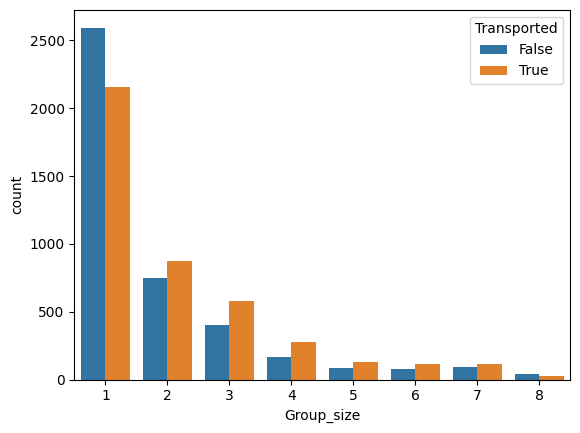

In [1048]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Group_size', hue='Transported', ax=ax)

### Age Analysis

Age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0
Transported,,,,,,,,,,,,,,,,,,,,,
False,33.0,17.0,22.0,16.0,18.0,13.0,17.0,18.0,20.0,16.0,...,3.0,4.0,2.0,6.0,2.0,2.0,1.0,1.0,2.0,3.0
True,142.0,48.0,51.0,58.0,52.0,20.0,23.0,32.0,26.0,24.0,...,5.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,NaN


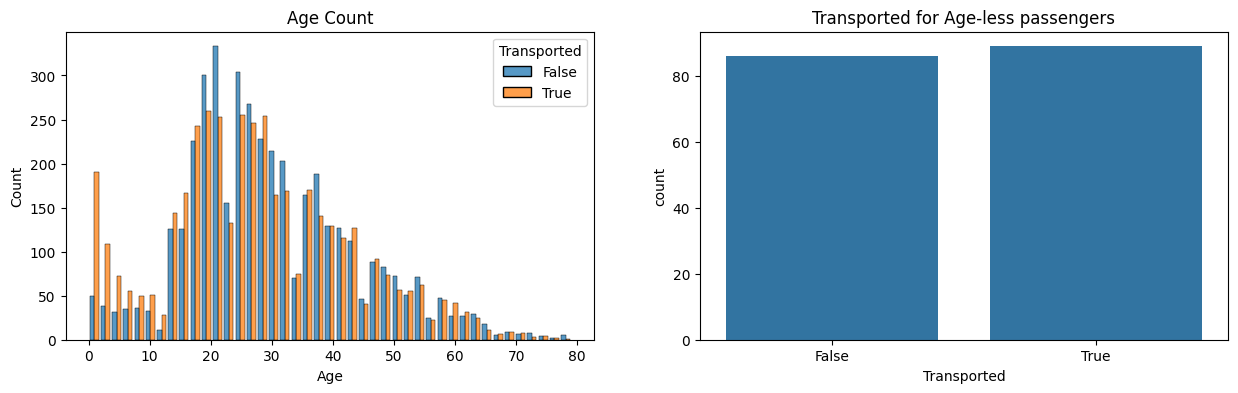

In [1049]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 4)
sns.countplot(data=dataset_df.loc[dataset_df.Age.isna()], x='Transported', ax=ax[1])
ax[1].set_title('Transported for Age-less passengers')
sns.histplot(data=dataset_df.dropna(subset=['Age']), x='Age', hue='Transported', multiple='dodge', shrink=.8, ax=ax[0])
ax[0].set_title('Age Count')

table = pd.pivot_table(data=dataset_df.dropna(subset=['Age']), index=['Transported'], columns=['Age'], aggfunc='size')
table

Observations: 
- It seems passengers of age $\lt 13$ are likelier to be transported than passengers $\gt 12$.
- Whether or not the passenger's age is known doesn't seem to affect their chance of being transported.

In [1050]:
dataset_df = dataset_df.dropna(subset=['Age']) # drop null Age passengers

dataset_df['Age_gt12'] = dataset_df.Age.apply(lambda x: x > 12)
dataset_df.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,F_name,S_name,Group,Group_id,Group_size,Age_gt12
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,Maham,Ofracculy,0001,01,1,True
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,Juanna,Vines,0002,01,1,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,Altark,Susent,0003,01,2,True
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,Solam,Susent,0003,02,2,True
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,Willy,Santantines,0004,01,1,True


<AxesSubplot: xlabel='Age_gt12', ylabel='count'>

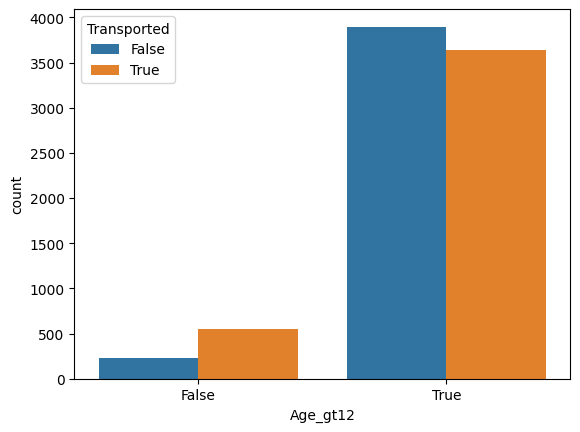

In [1051]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Age_gt12', hue='Transported')

### Destination Analysis

In [1052]:
dataset_df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', 'Unknown'],
      dtype=object)

In [1053]:
dest_dict = {'TRAPPIST-1e': 'T', 'PSO J318.5-22': 'P', '55 Cancri e': 'C', 'Unknown': 'U'}
dataset_df.Destination = dataset_df.Destination.map(dest_dict)

<AxesSubplot: xlabel='Destination', ylabel='count'>

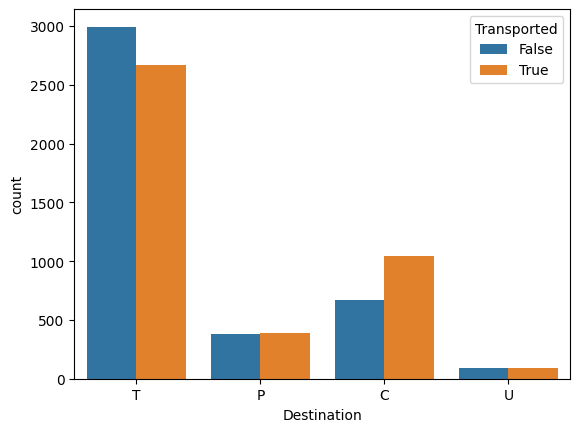

In [1054]:
fig, ax = plt.subplots(1,1)
sns.countplot(data=dataset_df, x='Destination', hue='Transported')

### Convert Booleans to Integers

In [1055]:
# Convert Bool to Int
dataset_df.Side = dataset_df.Side.apply(lambda x: True if x == 'P' else False)
dataset_df[['CryoSleep','VIP','Transported', 'Side']] = dataset_df[['CryoSleep','VIP','Transported', 'Side']].astype(int)

## Training Random Forest with Scikitlearn

In [1056]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [1057]:
X  = dataset_df.drop(labels=['Name', 'Transported', 'F_name', 'Group_id'], axis=1)
y = dataset_df.Transported

X.head(5)

KeyError: "['Name'] not found in axis"

In [ ]:
encoder = OneHotEncoder(drop='if_binary')

categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Cabin_num', 'Side', 'S_name', 'Group']

new_categorical_features = encoder.fit_transform(X[categorical_features])
new_categorical_features = pd.DataFrame(new_categorical_features.toarray(), columns=encoder.get_feature_names_out(categorical_features), index=X.index)
X = pd.concat([X.drop(columns=categorical_features),new_categorical_features], axis=1)
X.head(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_size,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Group_9267,Group_9268,Group_9270,Group_9272,Group_9274,Group_9275,Group_9276,Group_9278,Group_9279,Group_9280
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,2,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1, stratify=y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(random_state=1, max_depth=10, max_leaf_nodes=3)

clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7200601051840722

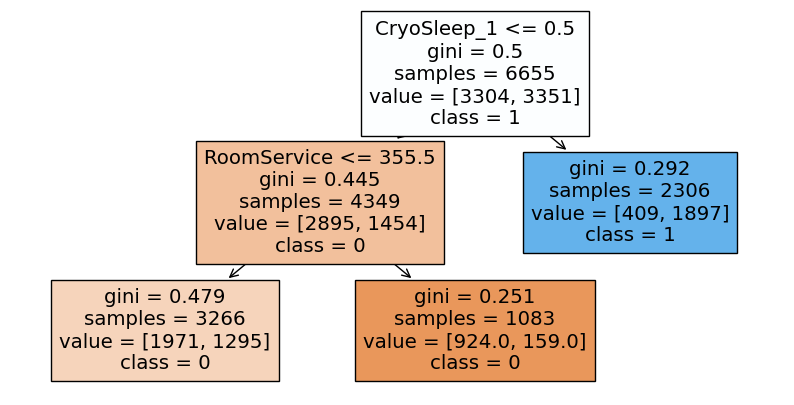

In [ ]:
plt.figure(figsize=(10,5))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=y.unique().astype(str))
plt.show()

In [ ]:
clf.score(X_test, y_test)

0.7043269230769231